### Deep Q-Network from scratch

### MLP setup and hyperparameters
Setup hyperparameters and state tracking with simple MLP definition

In [60]:
# Steps:
# 1. Create pytorch simple mlp model
# 2. Implement dqn algorithm with mlp model
# 3. Test algorithm in certain environment

import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import random
from collections import deque
import matplotlib.pyplot as plt
from enum import Enum

class MLP(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.fc1 = nn.Linear(in_dim, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, out_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class EnvType(Enum):
    CARTPOLE = "CartPole-v1"
    FROZENLAKE = "FrozenLake-v1"

class DQNEnvironmentWrapper:
    def __init__(self, env_type, render_mode, max_episode_steps):
        if not isinstance(env_type, EnvType):
            raise ValueError("env_type must be an EnvType enum")

        self.env_type = env_type
        self._env = gym.make(env_type.value, render_mode=render_mode, max_episode_steps=max_episode_steps)

        if env_type == EnvType.CARTPOLE:
            self.obs_space_dim = 4  # [position, velocity, angle, angular_velocity]
            self.action_space_dim = 2  # [left, right]
        elif env_type == EnvType.FROZENLAKE:
            self.obs_space_dim = 16  # One-hot encoded vector (4x4 grid = 16 states)
            self.action_space_dim = 4  # [left, down, right, up]

    def _process_observation(self, obs):
        if self.env_type == EnvType.FROZENLAKE:
            one_hot = torch.zeros(self.obs_space_dim, dtype=torch.float32)
            one_hot[obs] = 1.0
            return one_hot
        else:
            return torch.tensor(obs, dtype=torch.float32)

    def reset(self):
        obs, info = self._env.reset()
        processed_obs = self._process_observation(obs)
        return processed_obs, info

    def step(self, action):
        obs_next, reward, terminated, truncated, info = self._env.step(action)
        processed_obs_next = self._process_observation(obs_next)
        return processed_obs_next, reward, terminated, truncated, info

    def sample_action_space(self):
        return self._env.action_space.sample()

    def close(self):
        self._env.close()


# Implement dqn algorithm
replay_cap = 10000
episodes = 1000
max_episode_steps = 500
# Use linear epsilon decay to encourage high exploration in the beginning
# Hyperparams for cartpole
# eps = 0.9
# eps_end = 0.01
# discount = 0.99
# Hyperparams for frozen lake
eps = 0.9
eps_end = 0.07
discount = 0.9
C = 100
minibatch_size = 64
env = DQNEnvironmentWrapper(EnvType.FROZENLAKE, render_mode='human', max_episode_steps=max_episode_steps)

# Init replay memory with capacity replay_cap
replay_mem = deque(maxlen=replay_cap)
# Init action-value func Q w/ random weights
q = MLP(env.obs_space_dim, env.action_space_dim)
# Init target action-value func w/ random weights (separate selecting best action and updating val for training stabilization)
q_hat = MLP(env.obs_space_dim, env.action_space_dim)
# Init optimizer
optimizer = torch.optim.AdamW(q.parameters(), lr=3e-4)
# Init c counter
c_step = 0
# Init episode steps tracking
episode_steps = []

### Training run

In [61]:
# Each episode represents how long we run through the env each time. This is different from the horizon which signifies how far ahead we're optimizing the reward path for (we assume infinite horizon)
for episode in range(episodes):
    # Init state
    obs, _ = env.reset()
    episode_over = False
    step = 0

    while not episode_over:
        step += 1
        # Get random action with prob eps or act greedily
        obs = torch.tensor(obs, dtype=torch.float32)
        if torch.rand(1) < eps:
            action = env.sample_action_space()
        else:
            q_out = q(obs)
            # We use q network to select action
            action = torch.argmax(q(obs)).item()

        # Execute action in emulator and observe reward and next state
        obs_next, reward, terminated, truncated, _ = env.step(action)
        episode_over = terminated or truncated

        # Store new experience in replay memory
        replay_mem.append((obs, action, reward, obs_next, episode_over))

        # Sample random minibatch from replay mem
        minibatch = random.sample(replay_mem, len(replay_mem) if len(replay_mem) < minibatch_size else minibatch_size)
        y_j = torch.tensor([float(exp[2]) if exp[4] else float(exp[2]) + discount * torch.max(q_hat(torch.tensor(exp[3], dtype=torch.float32))).item() for exp in minibatch], dtype=torch.float32)

        # Calculate loss and perform gradient descent step
        q_vals = q(torch.stack([torch.tensor(exp[0]) for exp in minibatch]))
        actions = torch.tensor([exp[1] for exp in minibatch])
        q_vals = q_vals[torch.arange(len(minibatch)), actions]
        loss = F.mse_loss(q_vals, y_j)

        # Do only one gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update state
        obs = obs_next
        c_step += 1

        # Every C steps, copy weights from Q to Q_hat
        if c_step % C == 0:
            q_hat.load_state_dict(q.state_dict())

    # Store episode steps
    episode_steps.append(step)
    print(f"Finished episode {episode}, steps: {step}, eps: {eps}")
    eps = max(eps_end, eps - 0.001)

print("Finished training")

env.close()

/var/folders/p6/sx805f6s2llg753msgs16xfr0000gn/T/ipykernel_32415/393378024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32)
/var/folders/p6/sx805f6s2llg753msgs16xfr0000gn/T/ipykernel_32415/393378024.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_j = torch.tensor([float(exp[2]) if exp[4] else float(exp[2]) + discount * torch.max(q_hat(torch.tensor(exp[3], dtype=torch.float32))).item() for exp in minibatch], dtype=torch.float32)
/var/folders/p6/sx805f6s2llg753msgs16xfr0000gn/T/ipykernel_32415/393378024.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().

Finished episode 0, steps: 11, eps: 0.9
Finished episode 1, steps: 22, eps: 0.899
Finished episode 2, steps: 3, eps: 0.898
Finished episode 3, steps: 2, eps: 0.897
Finished episode 4, steps: 2, eps: 0.896
Finished episode 5, steps: 3, eps: 0.895
Finished episode 6, steps: 8, eps: 0.894
Finished episode 7, steps: 12, eps: 0.893
Finished episode 8, steps: 19, eps: 0.892
Finished episode 9, steps: 6, eps: 0.891
Finished episode 10, steps: 2, eps: 0.89
Finished episode 11, steps: 6, eps: 0.889
Finished episode 12, steps: 7, eps: 0.888
Finished episode 13, steps: 10, eps: 0.887
Finished episode 14, steps: 2, eps: 0.886
Finished episode 15, steps: 19, eps: 0.885
Finished episode 16, steps: 4, eps: 0.884
Finished episode 17, steps: 3, eps: 0.883
Finished episode 18, steps: 6, eps: 0.882
Finished episode 19, steps: 6, eps: 0.881
Finished episode 20, steps: 6, eps: 0.88
Finished episode 21, steps: 21, eps: 0.879
Finished episode 22, steps: 7, eps: 0.878
Finished episode 23, steps: 10, eps: 0.87

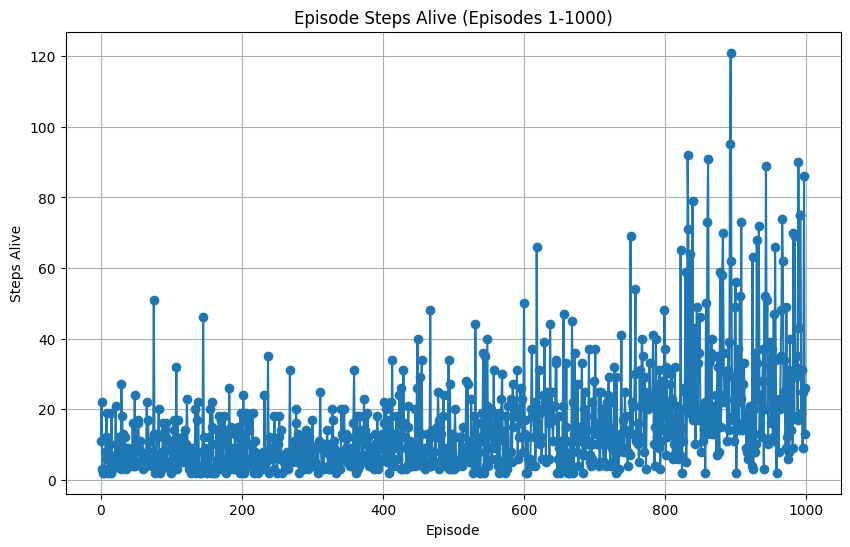

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(episode_steps, 'o-')
plt.title(f'Episode Steps Alive (Episodes 1-{episode + 1})')
plt.xlabel('Episode')
plt.ylabel('Steps Alive')
plt.grid(True)
plt.show()

In [63]:
# Demo agent running in test environment

input("Press Enter to start demo...")
print("Demo agent running in test environment")

test_env = DQNEnvironmentWrapper(EnvType.FROZENLAKE, render_mode='human', max_episode_steps=max_episode_steps)

q.eval()

obs, _ = test_env.reset()
steps = 0
lost = False
while not lost:
    action = torch.argmax(q(torch.tensor(obs))).item()
    obs_next, reward, terminated, truncated, _ = test_env.step(action)
    lost = terminated or truncated
    obs = obs_next
    steps += 1

print("Steps:", steps)
print("Finished demo")
test_env.close()

Demo agent running in test environment


/var/folders/p6/sx805f6s2llg753msgs16xfr0000gn/T/ipykernel_32415/2513456337.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.argmax(q(torch.tensor(obs))).item()


Steps: 11
Finished demo


### Reflection

I want to use this space to discuss some of the problems + conceptual unlocks I had while implementing dqn.

**Truly understanding q-values and value iteration**
When I first started I was introduced to the concept of tabular q-learning where each state/action pair had an associated temporal value assigned to it. While implementing dqn, for some reason I kept thinking about the time step and a fixed horizon. Mostly, this was caused by a conceptual misunderstanding where I thought of the episode max timesteps in the environment and the horizon as a same thing. I eventually realized that in dqn the agent acts to maximize the reward indefinitely (infinite horizon) which is why convergence is so important (something I glanced over while reading). Instead of in tabular q-learning where we had to associate a table for each timestep, with infinite horizons we only cared about the state and action! As the timestep goes to infinity, the next timestep optimal Q value is the same as the current optimal q value, and because of the discounting it will converge!

**Similarities between value iteration and dqn**
Another major aha moment was realizing that dqn is essentially value iteration but done through trial and error. Because of the corollary that value iteration converges to a unique fixed point. Regardless of our initial initialization of the q-network with random starting weights, each time we run through an episode is the same as doing value iteration starting from 0 timesteps left, to 1, etc... With enough episodes, our q-network will start to converge! Additionally, through trial and error, the q-network will learn to weighted average the q values based on the probability of different states.

**Problem with catastrophic forgetting**
Part of the way through, I started noticing that for some reason, my agent would succeed in keeping the cart pole up around 200 episodes in but then suddenly, it would act as if it forgot everything, only stay alive for around 20 timesteps and look like it's learning from scratch. This was insanely puzzling and after playing around with a number of hyperparameters, I realized that originally I had a fixed epsilon-greedy action policy while training that always took a random action 10% of the time. What was happening that most of the time, the agent was acting greedily and started overfitting its q-values to "easy" states where it was staying upright. Since the network was a small MLP, it would forget "rare" states and when it would suddenly reach a rare state, it would compound and fail. Very quickly, this would cause the agent to learn that "rare" states are bad when in reality they could've been good and just weren't experienced enough. To fix this, I added a simple linear decay to the epsilon-greedy policy that encouraged the agent to explore a lot early on. This improved the agent's test performance **significantly** and also got rid of this problem.
